In [1]:
import math
import tensorflow as tf
import numpy as np
from tensorflow.python.framework import ops

from test.imgload.imgload import loaddta

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from test.convolutional.convlayers import bias_variable
from test.convolutional.convlayers import conv2d
from test.convolutional.convlayers import conv_layer
from test.convolutional.convlayers import full_layer
from test.convolutional.convlayers import max_pool_2x2

def display(img):
    # (784) => (28,28)
    one_image = img.reshape(28, 28)
    plt.axis('off')
    plt.imshow(one_image, cmap=cm.binary)
    plt.show()


load img

In [2]:
X_loaded, Y_loaded = loaddta('../input/train.csv')

X_train = X_loaded[:, 0:39000]
Y_train = Y_loaded[:, 0:39000]
X_test = X_loaded[:, 39001:41999]
Y_test = Y_loaded[:, 39001:41999]


print('X_train shape:' + str(X_train.shape))
print('Y_train shape:' + str(Y_train.shape))
print('X_test shape:' + str(X_test.shape))
print('Y_test shape:' + str(Y_test.shape))

image_size => 784
image_width => 28
image_height => 28
X_train shape:(784, 39000)
Y_train shape:(10, 39000)
X_test shape:(784, 2998)
Y_test shape:(10, 2998)


###### display img:

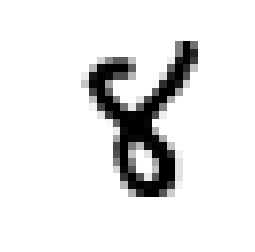

In [4]:
display(X_train[:, 3905])

###### Placeholders for minibatches:

In [5]:
x = tf.placeholder(tf.float32, shape=(None, 784))
y_ = tf.placeholder(tf.float32, shape=(None, 10))

In [6]:
x_image = tf.reshape(x, [-1, 28, 28, 1])

conv1 = conv_layer(x_image, shape=[5, 5, 1, 32])
conv1_pool = max_pool_2x2(conv1)

conv2 = conv_layer(conv1_pool, shape=[5, 5, 32, 64])
conv2_pool = max_pool_2x2(conv2)

conv2_flat = tf.reshape(conv2_pool, [-1, 7*7*64])
full_1 = tf.nn.relu(full_layer(conv2_flat, 1024))

keep_prob = tf.placeholder(tf.float32)
full1_drop = tf.nn.dropout(full_1, keep_prob=keep_prob)

y_conv = full_layer(full1_drop, 10)

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y_))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [11]:
print("conv1: " + str(conv1))
print("conv1_pool: " + str(conv1_pool))
print("conv2: " + str(conv2))
print("conv2_pool: " + str(conv2_pool))
print("conv2_flat: " + str(conv2_flat))
print("full_1: " + str(full_1))
print("y_conv: " + str(y_conv))

conv1: Tensor("Relu:0", shape=(?, 28, 28, 32), dtype=float32)
conv1_pool: Tensor("MaxPool:0", shape=(?, 14, 14, 32), dtype=float32)
conv2: Tensor("Relu_1:0", shape=(?, 14, 14, 64), dtype=float32)
conv2_pool: Tensor("MaxPool_1:0", shape=(?, 7, 7, 64), dtype=float32)
conv2_flat: Tensor("Reshape_1:0", shape=(?, 3136), dtype=float32)
full_1: Tensor("Relu_2:0", shape=(?, 1024), dtype=float32)
y_conv: Tensor("add_3:0", shape=(?, 10), dtype=float32)


In [7]:
def random_mini_batches(X, Y, mini_batch_size=64):

    m = X.shape[1]
    mini_batches = []

    # Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0], m))
    #print("shuffled_Y: " + str(shuffled_Y.shape))

    # Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(
        m / mini_batch_size)  # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size: k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size: k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    # Handling end case where last mini-batch < mini_batch_size
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size: m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size: m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches


In [13]:
minibatch_testX = random_mini_batches(X_train, Y_train)

In [8]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(100):
        epoch_cost = 0.
        m = X_train.shape[1]
        minibatch_size = 128
        num_minibatches = int(m / minibatch_size)
        minibatches = random_mini_batches(X_train, Y_train, minibatch_size)
        
        for minibatch in minibatches:
            xt = minibatch[0].T
            yt = minibatch[1].T
            xt = xt.astype(np.float32)
            sess.run(train_step, feed_dict={x: xt, y_: yt, keep_prob: 0.45})
        
        if epoch % 5 == 0:
            dev_accuracy = sess.run(accuracy, feed_dict={x: X_test.T, y_: Y_test.T, keep_prob: 1.0})
            print("EPOCH {}, dev accuracy {}".format(epoch, dev_accuracy))  
            train_accuracy = sess.run(accuracy, feed_dict={x: X_train.T, y_: Y_train.T, keep_prob: 1.0})
            print("EPOCH {}, training accuracy {}".format(epoch, train_accuracy))
            
            
            
        

EPOCH 0, dev accuracy 0.9369579553604126
EPOCH 0, training accuracy 0.9364102482795715
EPOCH 5, dev accuracy 0.9739826321601868
EPOCH 5, training accuracy 0.9838974475860596
EPOCH 10, dev accuracy 0.9826551079750061
EPOCH 10, training accuracy 0.9923076629638672
EPOCH 15, dev accuracy 0.9853235483169556
EPOCH 15, training accuracy 0.9961282014846802
EPOCH 20, dev accuracy 0.987991988658905
EPOCH 20, training accuracy 0.9982820749282837
EPOCH 25, dev accuracy 0.987991988658905
EPOCH 25, training accuracy 0.999179482460022
EPOCH 30, dev accuracy 0.9893262386322021
EPOCH 30, training accuracy 0.9998205304145813
EPOCH 35, dev accuracy 0.9886590838432312
EPOCH 35, training accuracy 0.9996410012245178


KeyboardInterrupt: 